<img src="costarica_dibujo.PNG" width=200 align="center">

<h1 align="center">Taller de Introducción al  Aprendizaje Automático con Aplicaciones a Focalización de Políticas Públicas</h1> 

<h3 align="center">Alejandro Noriega Campero</h3>
<h3 align="center">Luis Fernando Cantú Díaz de León</h3>
<h3 align="center">Costa Rica, 2019</h3> 

<h1 align="center">Bloque IV: Evaluación del Desempeño Predictivo</h1> 

## Índice de contenidos <a name="a1"></a>

 4.1 [Puntos de corte](#b1)
 
 4.2 [Mejoras en inclusión y exclusión](#b2)
 
 4.3 [Confianza estadística](#b3)
 
 4.4 [Medición de desempeño en subgrupos](#b4)
 
 4.5 [El camino fácil](#b5)

## 4.1 Puntos de corte <a name="b1"></a>

[Regresar al índice](#a1)

Una vez que decidimos cuál predictor vamos a utilizar, es fácil hacer que genere predicciones. Abajo, seleccionaremos el mejor predictor usando todas las variables interactuadas.

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# La librería sklearn tiene una sección completa de métricas que usaremos en esta sección.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Usaremos librerías del cuaderno pasado
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


**Retomamos el trabajo del Bloque III.**

In [24]:
# Retomaremos la celda del código pasado que genera la base interactuada
from sklearn.model_selection import train_test_split

# Cargamos la tabla completa
df = pd.read_csv("../datos/base_por_hogar.csv")

# Variables permitidas
vars_permitidas = ['V2A1','V8','V9','V18A1','V18B1','V18F1','V18G1','V18Q1','V18J1','V18L1','V18M1','R4H1','R4H2','R4H3','R4M1','R4M2','R4M3','R4T1','R4T2','R4T3','TamHog','TamViv','A5_mean','A5_sd','Escolari_mean','Escolari_sd','REZ_ESC_mean','REZ_ESC_sd','ZONA_2','V1_2','V1_3','V1_4','V1_5','V1_6','V2A_2','V2A_3','V2A_4','V2A_5','V3_1','V3_2','V3_3','V3_4','V3_5','V3_6','V3_7','V3_8','V4_1','V4_2','V4_3','V4_4','V4_5','V5_1','V6_1','V6_2','V6_3','V6_4','V6_5','V7A_2','V7A_3','V7B_2','V7B_3','V7C_2','V7C_3','HacDor_2','HacApo_2','V11_1','V11_2','V11_3','V12_2','V12_3','V12_4','V12_5','V12_6','V12_7','V13A_1','V13A_2','V13A_3','V13A_4','V13A_5','V14A_1','V15_1','V15_2','V15_3','V15_4','V15_5','V15_6','V16_1','V16_2','V16_3','V17A_2','V17A_3','V17A_4','V17A_5','V17A_6','V18A_2','V18B_4','V18C_6','V18D_8','V18F_4','V18G_6','V18Q_2','V18J_4','V18L_8','V18M_2','V18O_4','V18P_6','V19_1','V19C_0','V19C_1','ZONA']

# Definimos variables de la regresión: X, y
X = df.loc[:,vars_permitidas]
y = df.loc[:,"pobreza"]

# Generamos interacciones 1-a-1
for s in range(len(vars_permitidas)):
    print(s, end="\r")
    for k in range(s, len(vars_permitidas)):            # Para cada variable agregamos su producto con todas las variables que la suceden en nuestra lista de variables.
        X[vars_permitidas[s]+"_"+vars_permitidas[k]] = X[vars_permitidas[s]] * X[vars_permitidas[k]]

# Normalizamos las X
X = ((X - X.mean()) / X.std()).dropna(axis=1)

# Resultado: lista de variables interactuadas
variables_interactuadas = list(X.columns)
random.seed(51)
random.shuffle(variables_interactuadas)

**Entrenamos una regresión** logística regularizada con `C=0.1`, utilizando solo datos de entrenamiento.

In [25]:
# Dividimos la muestra
X_train, X_test, y_train, y_test =  train_test_split(X.iloc[:,:2048], y, test_size = 0.50, random_state = 5676)

#Creamos objeto predictor con regularización
est = LogisticRegression(penalty = "l1", C = 0.01, solver= "liblinear", random_state = 456)

#Entrenamos al predictor con las bases de entrenamiento
est.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=456, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### Predicciones con ScikitLearn

Las funciones **```.predict```** y **```.predict_proba```** generan predicciones para nuevos datos. 

Crearemos una **nueva tabla para guardar los resultados de nuestras predicciones fuera de muestra**.

In [16]:
# Creamos un nuevo dataframe (tabla), para guardar las predicciones
predicciones = pd.DataFrame()

# Agregamos la y verdadera
predicciones['y'] = y_test.copy()

# Agregamos una columna de predicción al nuevo dataframe
predicciones["prediccion"] = est.predict(X_test)

# Obtenemos las probabilidades
predicciones["probabilidad_pobreza"] =   [ps[1] for ps in  est.predict_proba(X_test) ]

predicciones.head(5)

,y,prediccion,probabilidad_pobreza
9713,0,0,0.468929
175,0,0,0.144699
1361,0,0,0.173389
2298,0,0,0.209798
1049,0,0,0.074058


Nota: El predictor da por default un $1$ si la probabilidad estimada de que el hogar este en situación de pobreza es mayor a $0.5$, y $0$ si la probabilidad es menor a este valor.

Por último guardamos **información de los subgrupos poblacionales**, que nos serviran posteriormente para evaluar la precisión para cada subgrupo poblacional 

In [17]:
# Variables de subgrupos
indices = predicciones.index.values
predicciones['StrFamilyType'] = df.iloc[indices]['StrFamilyType']
predicciones['urban']         = df.iloc[indices]['urban']

predicciones.head(5)

,y,prediccion,probabilidad_pobreza,StrFamilyType,urban
9713,0,0,0.468929,bi-parental,1
175,0,0,0.144699,adultos_y_mayores,1
1361,0,0,0.173389,bi-parental,0
2298,0,0,0.209798,adultos_y_mayores,1
1049,0,0,0.074058,adultos_y_mayores,1


### 4.1.1 Elegir un umbral de decisión

Una vez que tenemos las probabilidades, podemos calcular los errores de exclusion e inclusión bajo distintos umbrales de decisión. Abajo veremos como se distribuyen las probabilidades.

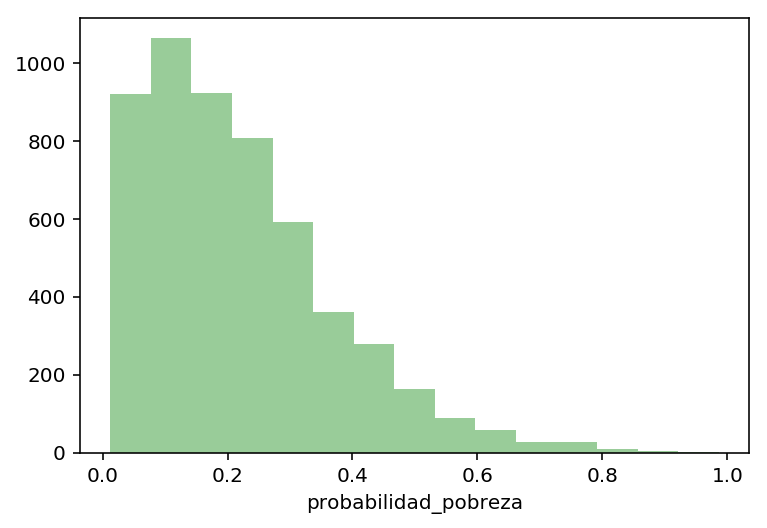

In [18]:
# Aquí graficamos la probabilidad de pobreza "predicha" para todos los hogares
sns.distplot(predicciones["probabilidad_pobreza"], kde = False, rug = False, hist = True, bins = 15, color = "green");

<font color = "blue"> Ejercicio: </font> Genera un gráfico que contenga la densidad de probabilidades solamente de los hogares en situación de pobreza. 
<br>
<font color = "blue">Tip:</font> los filtros que usamos en el cuaderno pasado se generaban con la misma base que íbamos a filtrar. Por ejemplo un filtro podía ser ```df[df["pobreza"] == 1]```. 

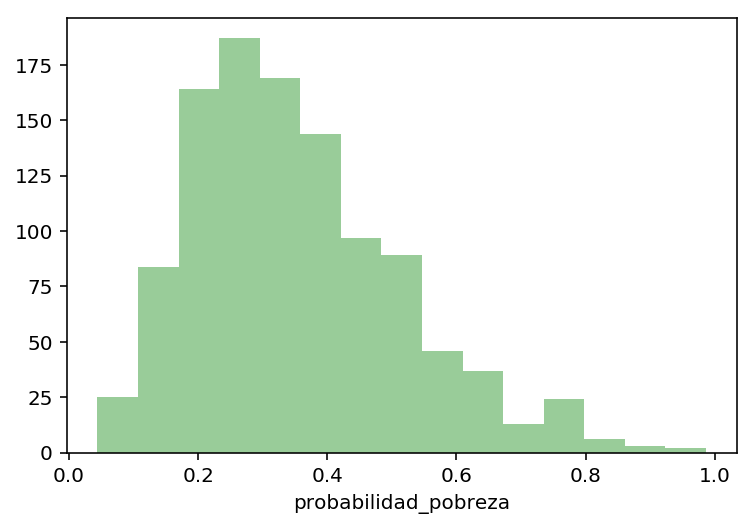

In [19]:
#Solución
#El filtro renglones conserva hogares en situación de pobreza.
filtro_renglones = (predicciones.y == 1)

#Hacemos el mismo gráfico que antes, pero agregamos el filtro ¡y ya está!
sns.distplot(predicciones[filtro_renglones].probabilidad_pobreza, kde = False, rug = False, hist = True, bins = 15, color = "green");


<font color = "blue"> Ejercicio: </font>Ahora genera un gráfico que contenga la densidad de probabilidades de los hogares no pobres sobrepuestos a la densidad de los hogares pobres. Para diferenciarlos colorea los _bins_ de los hogares pobres de azul y los de los hogares no pobres de café.

<font color = "blue"> Tip: </font> al usar la función ```plt.show()``` en el cuaderno pasado se iniciaba una nueva gráfica. Al no usarla, todos los objetos gráficos generados en una celda se sobrepondrán solos. 

<font color = "blue"> Tip: </font>Al final agrega el siguiente comando: ```plt.yscale('log')```. Observa como se ve la gráfica con y sin esta modificación. ¿Qué provoca?

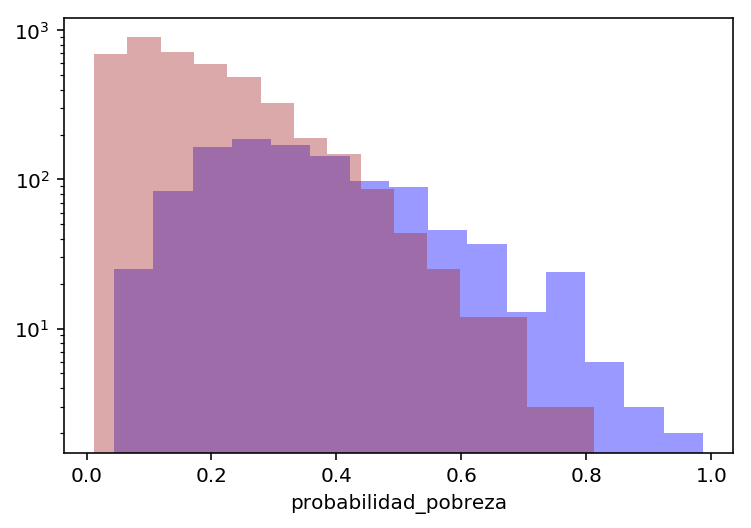

In [22]:
#Solución

#Aquí repetimos el gráfico de la celda anterior
filtro_renglones = (predicciones.y == 1)

sns.distplot(predicciones[filtro_renglones].probabilidad_pobreza, kde = False, hist = True, bins = 15, color = "blue");

#Aquí repetimos el gráfico de la celda anterior cambiando el filtro de hogares pobres a hogares no pobres
filtro_renglones = (predicciones.y == 0)

sns.distplot(predicciones[filtro_renglones].probabilidad_pobreza, kde = False,  hist = True, bins = 15, color = "brown");

#Esta función reescala el eje y para que ambas densidades se puedan ver claramente.
plt.yscale('log')

En la gráfica están de azul los hogares pobres y en café los no pobres. Ahora pensemos qué pasa si elegimos un umbral, a partir del cual consideramos que un hogar es elegible para una ayuda. Esto conlleva error de exclusión e inclusión. Abajo, generaremos un histograma que coloree el error de exclusión en los hogares pobres. 

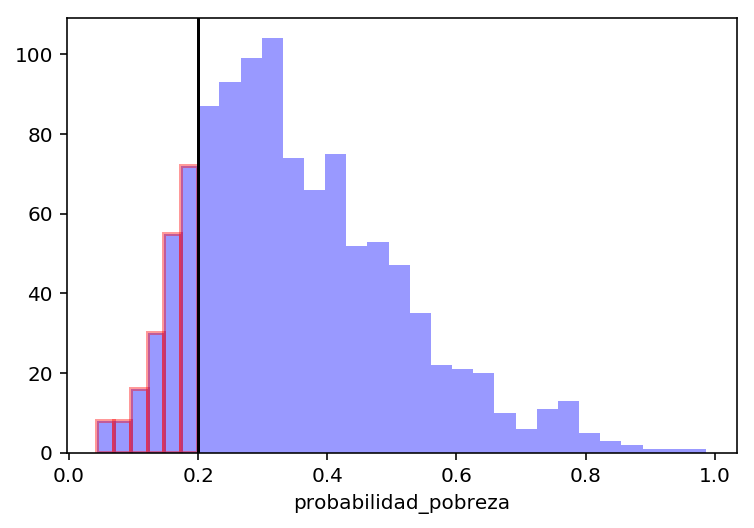

In [32]:
#En esta gráfica delinearemos los hogares excluídos para un valor del umbral de decisión.
  #La definiremos con una función para usarla en el siguiente ejercicio
    #¡Cambia el umbral muchas veces para observar como incluye en la exclusión!

def errores(umbral, predicciones,filtro1, color, resaltar):
    keywords2 = dict()
    keywords1 = dict()
    #Si el parámetro excl es igual a exclusión, se subrayarán los hogares abajo del umbral.
    #De otra forma, se subrayarán los errores arriba del umbral. 
    if resaltar == "exclusion":
        keywords2 = dict(edgecolor = "red", linewidth = 2)
        keywords1 = dict()
    if resaltar == "inclusion":
        keywords1 = dict(edgecolor = "red", linewidth = 2)
        keywords2 = dict()
    #El filtro renglones conserva hogares con el filtro1 no excluídos
    filtro_renglones_no_excluidos = filtro1 & (predicciones.probabilidad_pobreza >= umbral)

    #Hacemos el mismo gráfico que antes, coloreando a los hogares no excluídos de azul
    sns.distplot(predicciones[filtro_renglones_no_excluidos].probabilidad_pobreza, kde = False, rug = False, hist = True, bins = round(30*(1-umbral)), color = color, hist_kws = keywords1);

    #El filtro renglones conserva hogares con el filtro1 excluídos
    filtro_renglones_excluidos = filtro1 & (predicciones.probabilidad_pobreza<umbral)

    #Hacemos el mismo gráfico que antes, coloreando a los hogares excluídos de azul con delineado rojo. Aquí agregamos parámetros adicionales para lograrlo.
    sns.distplot(predicciones[filtro_renglones_excluidos].probabilidad_pobreza, kde = False, rug = False, hist = True, bins = 30-round(30*(1-umbral)), color = color, hist_kws = keywords2);

    #Graficamos una línea en el umbral
    plt.axvline(x = umbral, color = "black")


umbral = 0.2 
#Aquí llamamos la función. El string "exclusion" indica que queremos que se resalten los hogares excluídos.
filtro_pobreza = (predicciones.y == 1)
errores(umbral, predicciones,filtro_pobreza, "blue", "exclusion")


<font color = "blue">Ejercicio: </font>Utiliza el código anterior para sobreponer las distribuciones de hogares pobres y no pobres. Agrega un umbral tal que los hogares pobres excluídos y los hogares no pobres incluídos se delineen de rojo. Como en el ejercicio pasado, deja los hogares pobres de azul y los no pobres de café.

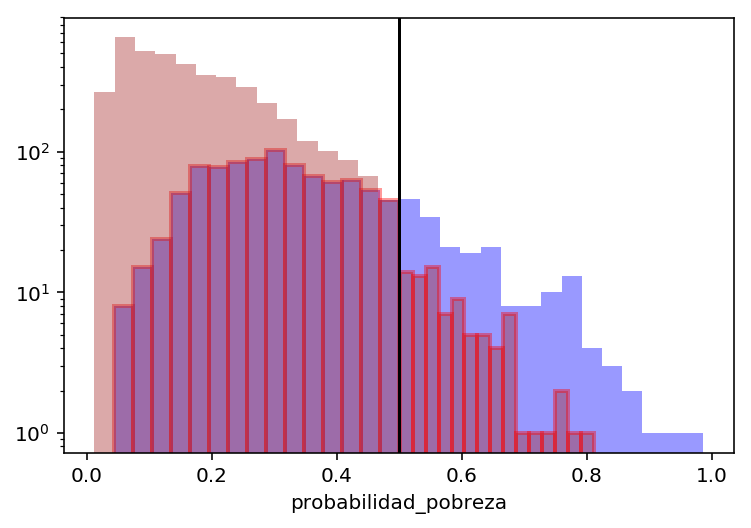

In [31]:
# Solución
umbral = 0.5

# Llamamos la función que genera la densidad de pobres resaltando el error
errores(umbral, predicciones,predicciones.y == 1, "blue", "exclusion")

# Modificamos la función para que tome hogares no pobres y resalte el error de inclusión 
errores(umbral, predicciones,predicciones.y == 0, "brown", "inclusion")

# Esta línea agrega una línea vertical sobre el umbral
plt.yscale('log')

<font color = "blue">Ejercicio:</font> En el bloque anterior podemos visualizar los errores. Ahora, completa las dos funciones de abajo que reciban un umbral, unas predicciones de probabilidad de pobreza, y un vector que identifique si el hogar es pobre o no. Una de ellas debe otorgar el error de exclusión y la otra el error de inclusión. 

<font color = "blue">Tip!</font> En muchas ocasiones has usado ya filtros en forma de listas, por ejemplo ```(predicciones.probabilidad_pobreza>umbral)```. Si aplicamos la función ```sum``` de ```numpy``` a un vector de falsos y verdaderos, se sumarán todos los valores tomando los verdaderos como unos y los falsos como 0s. Entonces, si queremos el total de hogares pobres, lo obtenemos así ```np.sum(predicciones['y'] == 1)```. 

In [29]:
# Solución
def error_excl(umbral, scores, pobreza):
    #Obtenemos el total de hogares pobres y total de hogares pobres no incluídos con np.sum
    total_pobres = sum(pobreza == 1)
    total_pobres_no_incluidos = sum((pobreza == 1) & (scores<umbral))
  
    #Definimos error de exclusión usando las variables que acabamos de definir
    error_excl = total_pobres_no_incluidos/total_pobres
    return error_excl

def error_incl(umbral, scores, pobreza):
    #Obtenemos el total de hogares incluídos y total de no pobres incluídos con np.sum
    total_incluidos = sum(scores>umbral)
    total_nopobres_incluidos = sum((pobreza == 0) & (scores>umbral))
  
    #Definimos error de inclusión usando las variables que acabamos de definir
    error_incl = total_nopobres_incluidos/total_incluidos
    return error_incl

Este umbral lo puedes cambiar a tu gusto. Cuando la probabilidad de pobreza es mayor a la del umbral, se considera que el hogar será incluído en el programa.


In [30]:
umbral = 0.25

error_exclusion = error_excl(umbral, predicciones.probabilidad_pobreza, predicciones['y'])
error_inclusion = error_incl(umbral, predicciones.probabilidad_pobreza, predicciones['y'])

print("El error de exclusión es: "+str(round(error_exclusion*100))+"% ")
print("El error de inclusión es: "+str(round(error_inclusion*100))+"% ")

El error de exclusión es: 30% 
El error de inclusión es: 59% 


Una vez resuelto el ejercicio, verifica que al subir el umbral se reduce el error de inclusión (es decir, se pide más evidencia para que un hogar sea clasificado pobre), además de que aumenta el error de exclusión. Lo inverso sucede cuando bajas el umbral.

## 4.1.2  Curvas de Error de Exclusión-Inclusión:  y Área Sobre la Curva


A veces preferimos poder evaluar la precisión de un algoritmo sin usar un umbral específico. Es decir, queremos ver qué tan bueno es el algoritmo sin tener que especificar un umbral si este es de 0.2, 0.5, 0.6, etc. En estas situaciones podemos utilizar la curva de error de inclusión vs. error de inclusión. Esta curva une todos los puntos alcanzables de errores usando las predicciones que tenemos. Existe gracias a que se puede alcanzar cualquier nivel de exclusión si subimos o bajamos la tolerancia a errores de inclusión. 

In [19]:
# La curva precision-recall es una medida de precisión común 
# y la librería sklearn la incluye como una función
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def inclusion_exclusion_curva(pobreza, probabilidades):
    precision, recall, thresholds = precision_recall_curve(pobreza,probabilidades)
    exclusion_errors = []
    inclusion_errors = []
  
    for elemento in precision:
        inclusion_error = 1-elemento
        inclusion_errors.append(inclusion_error)
    
    for elemento in recall:
        exclusion_error = 1-elemento
        exclusion_errors.append(exclusion_error)

    return inclusion_errors, exclusion_errors, thresholds

¡Probemos la función de arriba!

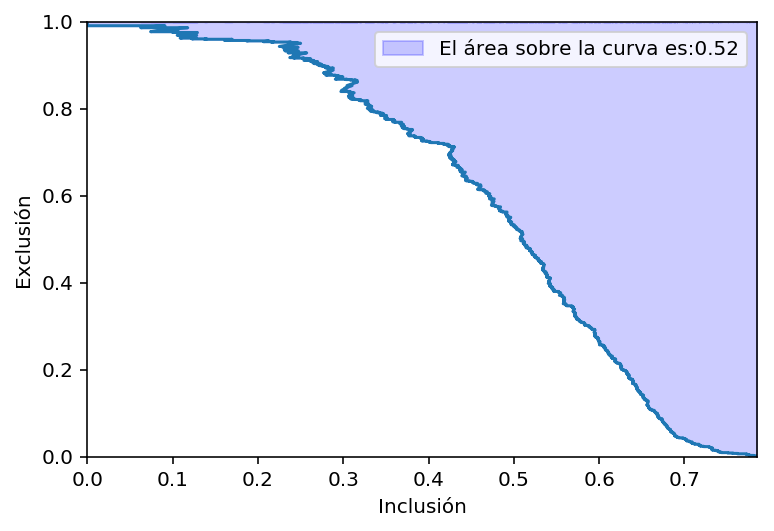

In [20]:
def area_sobre_curva(y, scores):
    #Aquí usaremos la función que creamos
    inclusion_errors, exclusion_errors, thresholds = inclusion_exclusion_curva(y, scores)

    #Aquí las graficamos como están
    plt.plot(inclusion_errors, exclusion_errors)

    plt.fill_between(inclusion_errors, exclusion_errors, 1, color = "blue", alpha = 0.2, label = "El área sobre la curva es:"+str(round(1-auc(exclusion_errors, inclusion_errors), 2)))
    
    plt.xlim([0,np.max(inclusion_errors)])
    plt.ylim([0,1])
    plt.xlabel("Inclusión"); plt.ylabel("Exclusión")
    plt.legend()
    plt.show()

area_sobre_curva(predicciones['y'],predicciones.probabilidad_pobreza)

<font color = "blue">Ejercicio: </font> ¿Es mejor un área sobre la curva cercana a 1 o a 0? Discute tu respuesta con tus compañeros.

// Tu respuesta aquí

#### Un Modelo Alternativo a Comparar: Regresión No-Regularizada

Podemos comparar esa área con el área que se obtiene con un modelo con menor regularización. Abajo la entrenamos.

In [21]:
# Aquí entrenamos un modelo sin regularización
est = LogisticRegression(penalty = "l1", C = 1.0, solver="liblinear", random_state= 456)
est.fit(X_train, y_train)
# Guardaremos las predicciones para tal modelo
predicciones["probabilidad_pobreza_noreg"] = [i[1] for i in est.predict_proba(X_test)]

<font color = "blue"> Ejercicio: </font> Imprime el área sobre la curva de las predicciones sin regularización y compárala con el área sobre la curva con regularización.

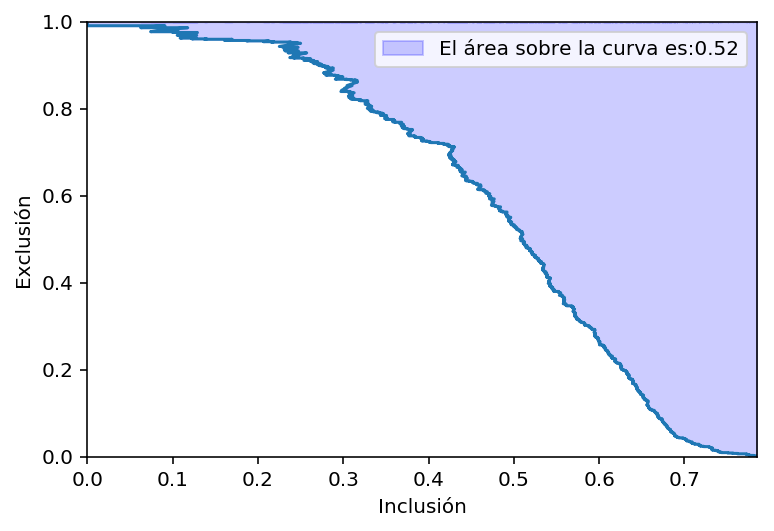

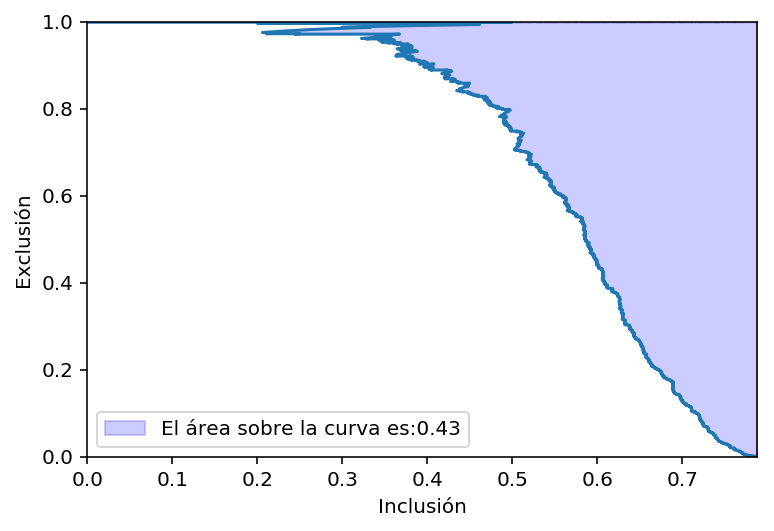

In [23]:
# Solución
area_sobre_curva(predicciones['y'], predicciones['probabilidad_pobreza'])
area_sobre_curva(predicciones['y'], predicciones['probabilidad_pobreza_noreg'])

## 4.2 Mejoras en Inclusión y Exclusión <a name="b2"></a>
[Regresar al índice](#a1)

<img src = "curva_CR.png" width = 500 align = "center"> 

Así como hay medidas que ofrecen el desempeño de un predictor sin compararlo con otro, hay medidas que comparan dos predictores. Ahora presentaremos una de ésas. ¿Qué tanto más bajo puede ser el error de exclusión entre dos algoritmos si dejo el error de inclusión igual en ambos? La misma pregunta se puede hacer para el error de exclusión. Para poder evaluar lo anterior, generaremos predicciones por el algoritmo no regularizado que usamos anteriormente. 

#### Calcular Error de Inclusión dado un nivel de Error de Exclusión Especificado

Ahora veremos cómo se comparan los errores de inclusión para un mismo error de exclusión

In [1]:
# Definimos esta función para obtener el índice del elemento más cercano al escalar de nuestra elección
def findclosest(lista, closer):
    kindex = 0
    mindist = abs(lista[0]-closer)
    index = 0
    for k in lista:
        if abs(k-closer)<mindist:
            mindist = abs(k-closer)
            kindex = index
        index+= 1
    return kindex

# Aquí obtendremos los errores de exclusión e inclusión para ambos predictores
inclusion_errors1, exclusion_errors1, thresholds = inclusion_exclusion_curva(predicciones['y'],predicciones.probabilidad_pobreza)
inclusion_errors2, exclusion_errors2, thresholds = inclusion_exclusion_curva(predicciones['y'],predicciones.probabilidad_pobreza_noreg)

# Encontramos el índice del lugar donde el error de inclusión es lo más cercano posible a 40% para ambos predictores
err_inclusion_deseado = .4
index1 = findclosest( exclusion_errors1, err_inclusion_deseado)
index2 = findclosest( exclusion_errors2, err_inclusion_deseado)

# Para los índices encontrados, los siguientres son los errores de exclusión/inclusión
print("Algoritmo con regularización")
print("  Exclusión: "+str(round(100*exclusion_errors1[index1]))+"%   Inclusión: "+str(round(100*inclusion_errors1[index1],1))+"%")

print("\nAlgoritmo sin regularización")
print("  Exclusión: "+str(round(100*exclusion_errors2[index2]))+"%   Inclusión: "+str(round(100*inclusion_errors2[index2],1))+"%") 

# Medimos la mejora como la diferencia relativa en errores de exclusión
print("\nReducción de exclusión: "+str(round(100*(inclusion_errors2[index2]-inclusion_errors1[index1])/inclusion_errors2[index2],1))+"%")


NameError: name 'inclusion_exclusion_curva' is not defined

## 4.3 Confianza estadística <a name="b3"></a>
[Regresar al índice](#a1)

Los resultados anteriores, por ejemplo el error de exclusión e inclusión, son estimaciones puntuales del error. Por lo tanto, si si hemos estimado un error de inclusión del 6%, es importante considerar que es muy probable que el error de inclusión poblacional sea de 5.9% o 6.1%. Incluso podría suceder que nuestro estimador puntual esté muy alejado del parámetro que estamos estimando. 

Es importante saber qué tanto nos podemos alejar del parámetro estimado, ya que un algoritmo cuya estimación puntual de error de exclusión es del 1%, pero cuyo intervalo de confianza para el error de exclusión con 95% de confianza va de 0.1 a 99.9% nos sería totalmente inútil. Para evitar lo anterior usamos el procedimiento **bootstrap**. 

El **bootstrap** consiste en simular distintos errores de exclusión bajo distintas submuestras de nuestros datos. Estas submuestras son del mismo número de observaciones que las de nuestra muestra original y se generan mediante un muestreo con reemplazo. Después de haber generado las submuestras, procedemos a calcular el error de exclusión en cada una de ellas. Finalmente, calculamos el error de exclusión promedio de las submuestras y obtenemos los intervalos de confianza. Por ejemplo, si el 95% de los errores de exclusión estuvo entre 4 y 8% en 1000 submuestras distintas, entonces podemos afirmar que, con un 95% de confianza, nuestro error final estará en ese mismo rango.

Luego, simularemos 1000 submuestras distintas. En cada simulación, usaremos `random.choices()` para obtener los índices de la muestra original que usaremos en cada muestra. Esta función realiza un muestreo con reemplazo de la lista entregada. La longitud de la nueva lista es la longitud de la lista original. Después, generaremos `new_scores` y `new_y`, que contienen la probabilidad de pobreza y el estátus de pobreza de cada observación en la lista muestreada. Usando la matriz de confusión generaremos un error de exclusión para cada muestra y lo agregaremos a un arreglo. 

In [2]:
# En esta función generaremos simulaciones bootstrap del error de exclusión

# En scores se recibe la lista de probabilidades de cada hogar y en y la pobreza
def exclusion_bootstrap(scores, y, umbral, print_res = True, n_boot = 300):

    # Para hacer nuestras muestras con reemplazo, iniciaremos enlistando todos los índices de observaciones que tenemos.
    lista = y.index

    # En exclusions guardaremos los errores de exclusión de cada simulación bootstrap
    exclusions = []
    inclusions = []
    
    # Cada muestra bootstrap
    for u in range(n_boot):
        print(u, end = "\r")

        # lista_aux trae una serie de índices de hogares obtenidos en muestreo con reemplazo
        random.seed(u)
        list_aux = random.choices(lista, k = len(lista))

        # Guardaremos las probabilidades y la pobreza de los hogares seleccionados en arreglos auxiliares que se 
          # redefinirán cada iteración.
        new_scores = []
        new_y = []
        for s in list_aux:
            new_scores.append(scores[s])
            new_y.append(y[s])

        # Para usar la función que tenemos de error_excl, debemos de convertir la lista a función
        new_scores = pd.Series(new_scores)
        new_y = pd.Series(new_y)
        new_exclusion = error_excl(umbral, new_scores, new_y)
        new_inclusion = error_incl(umbral, new_scores, new_y)
        exclusions.append(new_exclusion)
        inclusions.append(new_inclusion)
    # Graficamos la densidad de las exclusiones
    if print_res: 
        ax = sns.distplot(exclusions, kde = True, rug = False, hist = True)
        plt.axvline(x = np.mean(exclusions), color = "grey")
        plt.title("Distribución de Muestreo del Error de Exclusión"); 
        plt.xlabel("error de exclusion")
        plt.show()
  
    # Con base en los percentiles de las simulaciones, obtenemos un intervalo de confianza del 95%
    e_p25 = np.percentile(exclusions, 2.5)
    e_p975 = np.percentile(exclusions, 97.5)
    i_p25 = np.percentile(inclusions, 2.5)
    i_p975 = np.percentile(inclusions, 97.5)
    # Lo imprimimos
    if print_res: print("Intervalo de exclusión al 95% de confianza: ("+str(round(100*e_p25, 2))+"% ,"+str(round(100*e_p975, 2))+"%)")
  
    return e_p25, e_p975, i_p25, i_p975



Abajo viene la distribución de los errores de exclusión e imprimimos el percentil 2.5 y el 97.5 para obtener el intervalo de 95% de confianza.

In [3]:
umbral = .5
exclusion_bootstrap(predicciones["probabilidad_pobreza"], predicciones.y, umbral)

NameError: name 'predicciones' is not defined

## 4.4 Medición de Desempeño en Subgrupos <a name="b4"></a>
[Regresar al índice](#a1)

También podemos obtener el intervalo de confianza para distintas submuestras de nuestra población. Por ejemplo, hogares rurales. Hazlo en el siguiente ejercicio.

<font color = "blue">Ejercicio: </font> usa la función ```exclusion_bootstrap``` para obtener, para un umbral, un intervalo de confianza de la exclusión para hogares rurales y otro para hogares urbanos. Compáralos. 

In [4]:
# Solución para rurales
filtro_renglones = predicciones["urban"] == 0
exclusion_bootstrap(predicciones[filtro_renglones]["probabilidad_pobreza"], predicciones["y"][filtro_renglones], umbral)

# Solución para urbanos
filtro_renglones = predicciones["urban"] == 1
exclusion_bootstrap(predicciones[filtro_renglones]["probabilidad_pobreza"], predicciones["y"][filtro_renglones], umbral)

NameError: name 'predicciones' is not defined

Como se puede apreciar, **a menor población de prueba, más amplio es el intervalo de confianza**. Eso es porque es difícil obtener información de qué tan bien generalizará un algoritmo si tenemos muy pocas observaciones que le correspondan.

Podemos calcular el intervalo de confianza de cualquier punto que se encuentre sobre la curva de error de exclusión vs. error de inclusión.

In [5]:
# Esta función graficará un punto con su intervalo de confianza

def graficar_intervalos(th, score, y):
    # Obtenemos valores originales de exclusión e inclusión
    exclusion = error_excl(th, score, y)
    inclusion = error_incl(th, score, y)
  
    # Obtenemos percentiles de intervalos de confianza bootstrap
    e25, e975, i25, i975 = exclusion_bootstrap(score, y, th, print_res = False)
  
    # Graficamos los intervalos de confianza como líneas negras
    plt.plot( [inclusion, inclusion], [e25, e975], color = "black", zorder = 20)
    plt.plot( [i25, i975], [exclusion, exclusion], color = "black", zorder = 20)
  
    # Graficamos el punto original
    plt.scatter(inclusion, exclusion, s = 25, color = "red", zorder = 10)
  
    # Arreglamos ejes
    plt.ylabel('Error de exclusión')
    plt.xlabel('Error de inclusión')
    plt.ylim([0.0, 1.00])
    plt.xlim([0.0, 1.0])

umbral = .3
sns.set_style('whitegrid')
graficar_intervalos(.3, predicciones["probabilidad_pobreza"], predicciones['y'])
sns.set_style('white')

NameError: name 'sns' is not defined

Calcular el intervalo de confianza de un punto sobre la curva de error de inclusión vs. error de exclusión nos puede ser útil, ya que por medio de ellos se pueden hacer comparaciones entre diferentes modelos. Esto quiere decir que, para cualquier punto sobre la curva de un modelo (llamémosle _modelo1_), podemos hacer inferencia estadística con respecto a los puntos de otro modelo (_modelo2_ )de la siguiente manera:
+ Se estima el intervalo de confianza del punto escogido del _modelo1_, además del intervalo de confianza del punto con el mismo error de inclusión sobre la curva del _modelo2_ 
+ Se estima el intervalo de confianza del punto escogido del _modelo1_, además del intervalo de confianza del punto con el mismo error de exclusión sobre la curva del _modelo2_ 

En el siguiente bloque de código realizamos justamente este ejercicio y lo mostramos gráficamente para una mejor comprensión.

In [6]:
def comparar_curvas(y, scores1, scores2):
    # Aquí obtendremos los errores de exclusión e inclusión para ambos predictores
    inclusion_errors1, exclusion_errors1, thresholds1 = inclusion_exclusion_curva(y, scores1)
    inclusion_errors2, exclusion_errors2, thresholds2 = inclusion_exclusion_curva(y, scores2)
  
    # Graficamos la inclusión y exclusión de ambos predictores
    plt.figure(figsize = (9,9))
    plt.plot(inclusion_errors1, exclusion_errors1, label = "LASSO con C=0.01")
    plt.plot(inclusion_errors2, exclusion_errors2, label = "LASSO con C=1.0")
  
    # Obtenemos un punto de exclusión = 50% en el predictor sin regularización y lo graficamos
    s = findclosest(exclusion_errors2, 0.5)
  
    # Obtenemos dos índices en los errores del predictor con regularización. Uno donde el eraror de 
    # exclusión es igual al punto graficado, y otro análogo para el error de inclusión
    s11 = findclosest(exclusion_errors1, exclusion_errors2[s])
    s12 = findclosest(inclusion_errors1, inclusion_errors2[s])

    # Hacemos bootstrap para cada punto que encontramos, y graficamos su intervalo de confianza. 
    graficar_intervalos(thresholds1[s11], scores1, y)
    graficar_intervalos(thresholds1[s12], scores1, y)
    graficar_intervalos(thresholds2[s], scores2, y)
  
    plt.ylim([0.0, 1.00])
    plt.xlim([0.0, 1.0])
    plt.legend()


comparar_curvas(predicciones['y'], predicciones['probabilidad_pobreza'], predicciones['probabilidad_pobreza_noreg'])

NameError: name 'predicciones' is not defined

## 4.5 El camino fácil <a name="b5"></a>
[Regresar al índice](#a1)

También podemos lograrlo por medio de la librería `seaborn`:

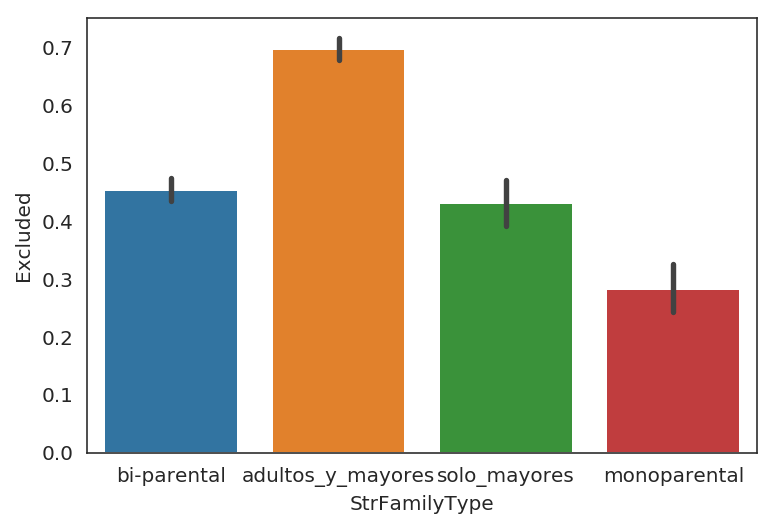

In [24]:
# Calculamos los hogares excluídos para algún umbral
umbral = 0.2
predicciones["Excluded"] = ( predicciones['probabilidad_pobreza'] < umbral )

# Al hacer una gráfica de barras en seaborn, automáticamente se generan intervalos de confianza bootstrap
sns.barplot(x = "StrFamilyType", y = "Excluded", data = predicciones)
plt.show()

## 4.6 Usando Validación Cruzada Para Aumentar el Tamaño de Muestra de Evaluación <a name="b5"></a>
[Regresar al índice](#a1)

Generamos predicciones fuera de muestra para cada hogar de la encuesta, utilizando el método de validación cruzada.

In [25]:
# Tabla con y verdadera y columnas de subgrupos
predicciones_cv = pd.DataFrame()
predicciones_cv['y']             = df['pobreza']
predicciones_cv['urban']         = df['urban']
predicciones_cv['StrFamilyType'] = df['StrFamilyType']
predicciones_cv['str_prov']      = df['str_prov']
display(predicciones_cv.head(3))

,y,urban,StrFamilyType,str_prov
0,1,0,adultos_y_mayores,Huetar Norte
1,1,0,bi-parental,Huetar Norte
2,0,1,solo_mayores,Central


In [40]:
##### Predicciones con validacion cruzada

def obtener_predicciones_con_validacion_cruzada(predicciones_cv, est, col_name):

    k = 3
    bloques =  [i for i in range(1,k+1)]

    # Asignar bloque a cada hogar
    n = len(df); nk = int(np.ceil(n/k)); l = []
    for i in bloques: 
        l.extend([i]*nk)
    random.Random(1).shuffle(l)
    predicciones_cv['bloque'] = l[:n]

    for k in bloques:

        print("Prediciendo bloque ", k, end = "\r")
        filtro_k = (predicciones_cv['bloque']==k)

        # obtener predicciones
        X_train =  X.loc[~filtro_k,  X.columns[:2048]]
        X_test  =  X.loc[ filtro_k,  X.columns[:2048]]
        y_train =  y[~filtro_k]
        y_test  =  y[filtro_k]
        est.fit( X_train, y_train )
        predicciones_cv.loc[ filtro_k, col_name] =  [ ps[1] for ps in est.predict_proba( X_test ) ]
        
   

In [41]:
# modelo 1
est = LogisticRegression(penalty = "l1", C = 0.01, solver= "liblinear", random_state = 456)    
obtener_predicciones_con_validacion_cruzada(predicciones_cv, est, 'probabilidad_pobreza')

In [42]:
# modelo 2
est = LogisticRegression(penalty = "l1", C = 1.0, solver="liblinear", random_state= 456)
obtener_predicciones_con_validacion_cruzada(predicciones_cv, est, 'probabilidad_pobreza_noreg')
display(predicciones_cv.head(10))

,y,urban,StrFamilyType,str_prov,bloque,probabilidad_pobreza,probabilidad_pobreza_noreg
0,1,0,adultos_y_mayores,Huetar Norte,2,0.365157,0.057348
1,1,0,bi-parental,Huetar Norte,1,0.707086,0.714932
2,0,1,solo_mayores,Central,2,0.068048,0.083425
3,0,1,adultos_y_mayores,Central,2,0.160369,0.030085
4,0,0,adultos_y_mayores,Chorotega,2,0.126446,0.013788
5,0,1,adultos_y_mayores,Central,1,0.062659,0.041131
6,0,1,adultos_y_mayores,Central,1,0.047391,0.000443
7,0,1,adultos_y_mayores,Central,1,0.083994,0.003028
8,0,0,bi-parental,Central,3,0.192362,0.021876
9,1,1,bi-parental,Pacífico Central,2,0.361712,0.301264


In [ ]:
# guardar tabla de predicciones
if False: predicciones_cv.to_csv("../datos/predicciones_cv.csv", index=False) 

Análisis de desempeño con datos de evaluación fuera de muestra en la tabla completa, generada con validación cruzada. 

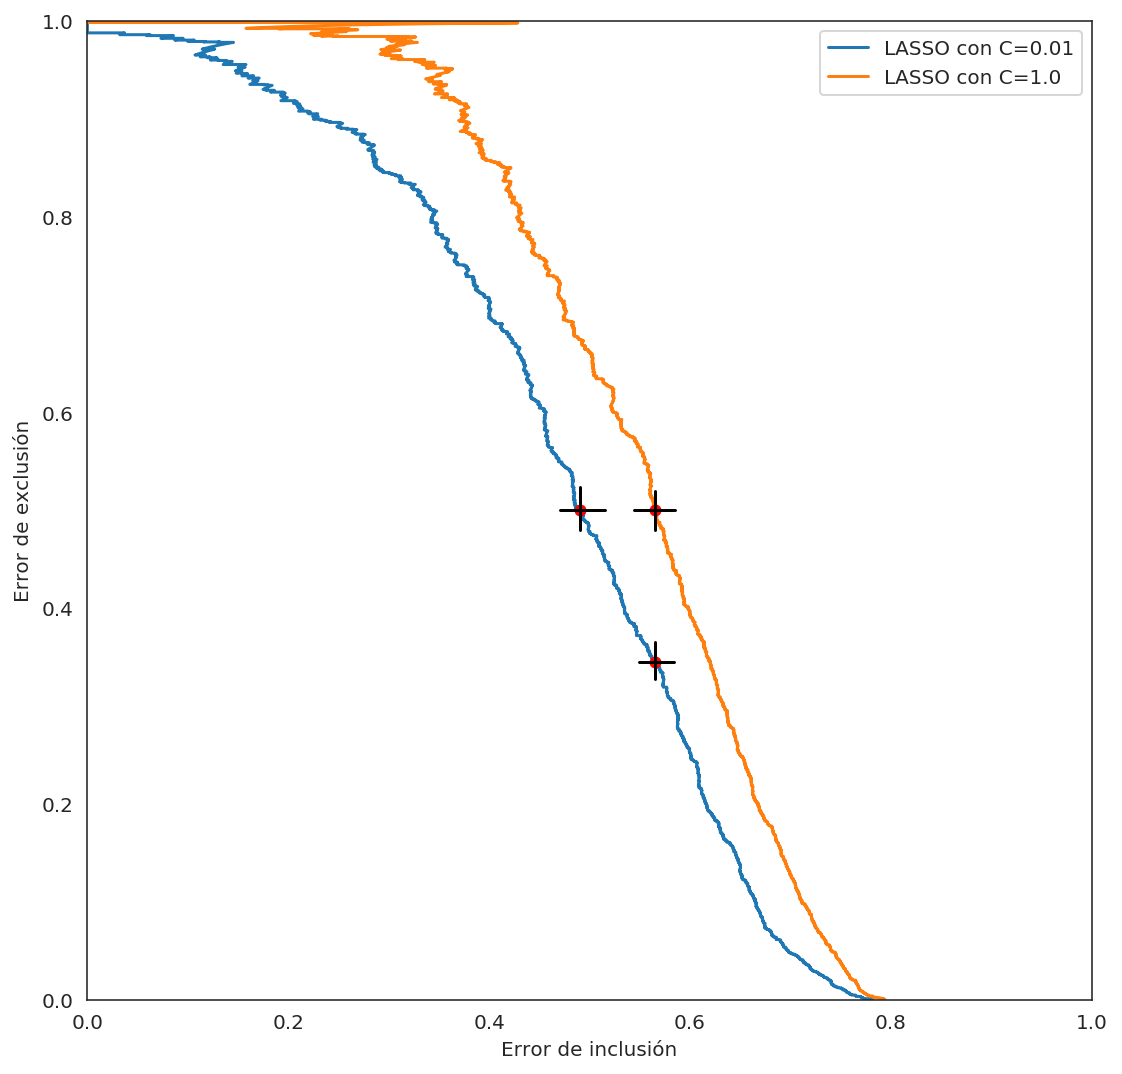

In [43]:
comparar_curvas(predicciones_cv['y'], 
                predicciones_cv['probabilidad_pobreza'], 
                predicciones_cv['probabilidad_pobreza_noreg'])

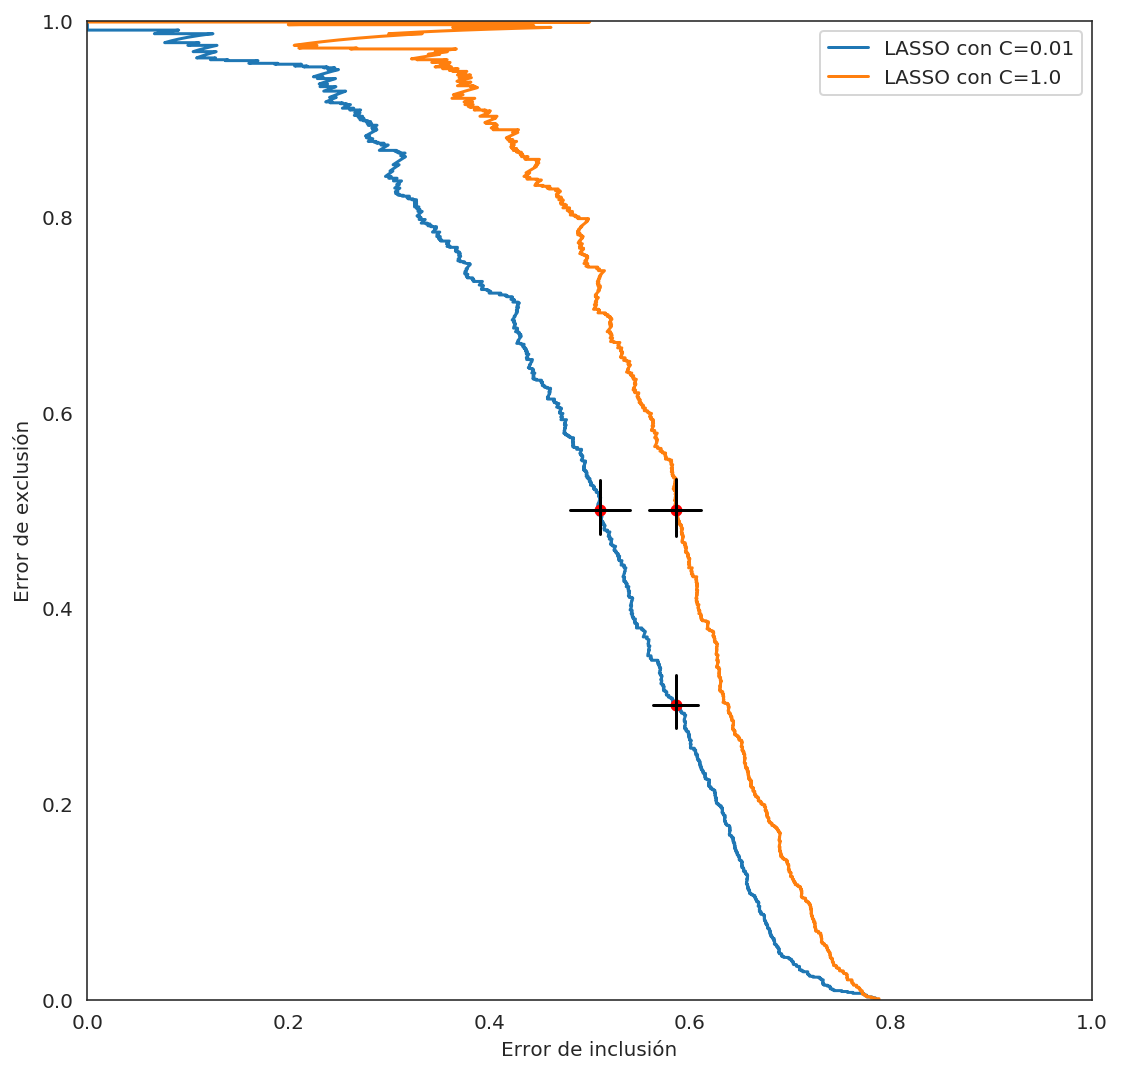

In [44]:
comparar_curvas(predicciones['y'], 
                predicciones['probabilidad_pobreza'], 
                predicciones['probabilidad_pobreza_noreg'])

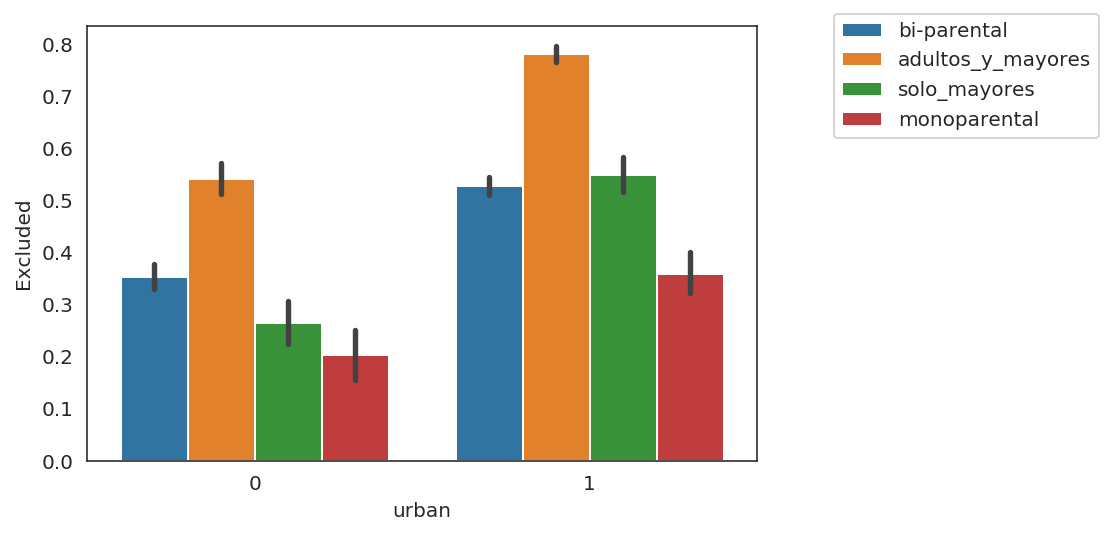

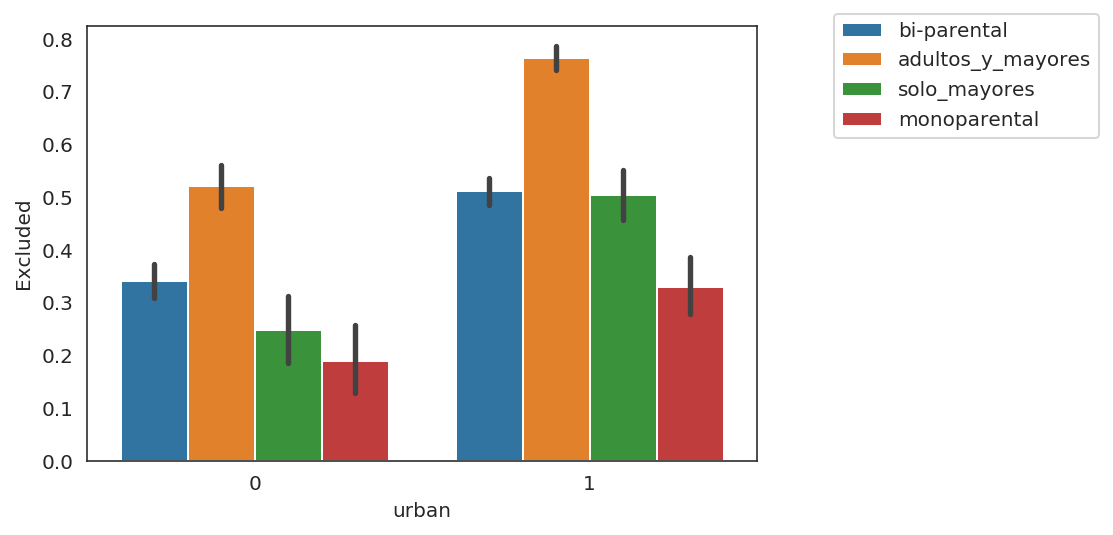

In [45]:
# Calculamos los hogares excluídos para algún umbral
umbral = 0.2
predicciones_cv["Excluded"] = ( predicciones_cv['probabilidad_pobreza'] < umbral )
ax = sns.barplot(x = "urban", y = "Excluded", hue= "StrFamilyType", data = predicciones_cv, hue_order = predicciones_cv["StrFamilyType"].value_counts().index)
ax.legend(bbox_to_anchor=(1.1, 1.05)); plt.show()

# Sin validación cruzada
predicciones["Excluded"] = ( predicciones['probabilidad_pobreza'] < umbral )
ax = sns.barplot(x = "urban", y = "Excluded", hue= "StrFamilyType", data = predicciones, hue_order = predicciones["StrFamilyType"].value_counts().index)
ax.legend(bbox_to_anchor=(1.1, 1.05)); plt.show()